In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from matplotlib.ticker import MaxNLocator
import ast

# Feature Importance

In [43]:
file_list_features = glob.glob('Results/Separate_Runs/*feature_importances30.csv')
file_list_features

['Results/Separate_Runs/(1, 0)_SARIMA_Boosted0_feature_importances30.csv',
 'Results/Separate_Runs/(1, 1)_SARIMA_Boosted0_feature_importances30.csv',
 'Results/Separate_Runs/(2, 0)_SARIMA_Boosted0_feature_importances30.csv']

In [44]:
features_sum = np.zeros((211,1))
# To extract only strækning=20
for file in file_list_features:
    print(file)
    features_df = pd.read_csv(file)
    features_sum += features_df.values

Results/Separate_Runs/(1, 0)_SARIMA_Boosted0_feature_importances30.csv
Results/Separate_Runs/(1, 1)_SARIMA_Boosted0_feature_importances30.csv
Results/Separate_Runs/(2, 0)_SARIMA_Boosted0_feature_importances30.csv


In [45]:
features_importances = features_sum / np.sum(features_sum) # Procent

In [46]:
max_indices = np.argpartition(features_importances, -10, axis=0)[-10:]
max_indices

array([[ 16],
       [125],
       [ 46],
       [126],
       [186],
       [ 18],
       [ 22],
       [129],
       [ 48],
       [ 14]])

In [47]:
data = pd.read_csv('Data/Cleaned_data.csv')
# Check shape fits
print(f'Data features: {data.shape[1]}')
print(f'Features from files: {features_importances.shape[0]}')

Data features: 213
Features from files: 211


In [48]:
max_features = data.columns.values[max_indices.flatten()]
max_values = features_importances[max_indices.flatten()].flatten()

In [49]:
max_values

array([0.01062423, 0.01126505, 0.01539402, 0.01338271, 0.01107291,
       0.0115203 , 0.0109043 , 0.0179726 , 0.02444434, 0.11942872])

In [50]:
def feature_importance_plot(feature_values):
    x_values = np.arange(len(feature_values))
    plt.barh(x_values, feature_values)
    plt.yticks(x_values, max_features, rotation=0, ha='right')
    plt.xlabel('Importances (%)')
    plt.title('Total Feature Importances')
    plt.grid()
    plt.show()

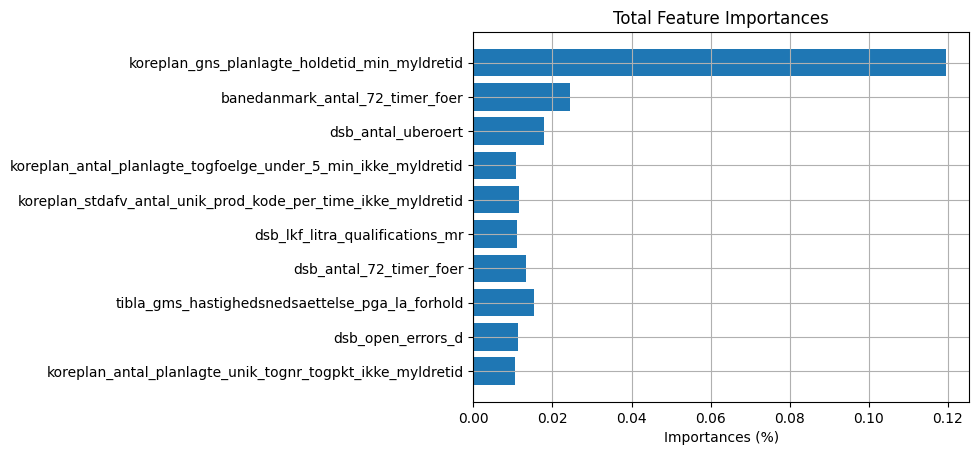

In [51]:
feature_importance_plot(max_values)

# Error

In [52]:
file_list_results = glob.glob('Results/Separate_Runs/*results30.csv')
file_list_results

['Results/Separate_Runs/(1, 1)_SARIMA_Boosted0_results30.csv',
 'Results/Separate_Runs/(2, 0)_SARIMA_Boosted0_results30.csv',
 'Results/Separate_Runs/(1, 0)_SARIMA_Boosted0_results30.csv']

In [53]:
strækning_station = []
errors_arima = []
errors_full = []
# To extract only strækning=20
for file in file_list_results:
    strækning_station += [file[22:].split('_')[0]]
    results_df = pd.read_csv(file)
    errors_arima += [results_df['Error_arima'][0]]
    errors_full += [results_df['Error_full'][0]]

In [54]:
def error_plot(strækning_station, errors_arima, errors_full):
    bar_width = 0.25
    index = range(len(errors_arima))

    plt.bar(index, errors_arima, bar_width, label='ARIMA')
    plt.bar([i + bar_width for i in index], errors_full, bar_width, label='Full')

    plt.xlabel('(Strækning, Station)')
    plt.ylabel('Error')
    plt.title('Error comparison for (Strækning, Station) pairs')
    plt.xticks([i + bar_width / 2 for i in index], [pair for pair in strækning_station])
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.grid()
    plt.show()

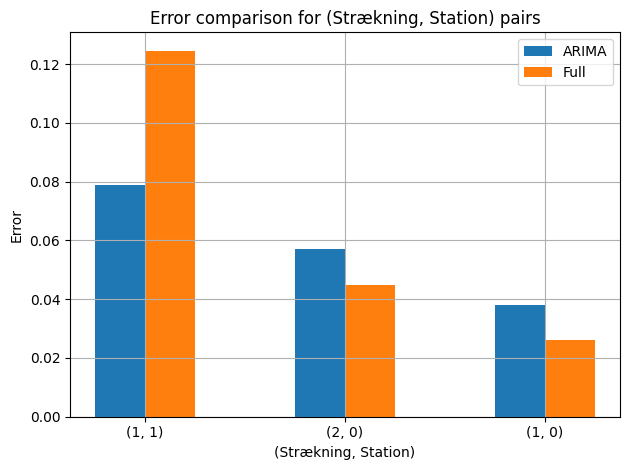

In [55]:
error_plot(strækning_station, errors_arima, errors_full)

# CV scores

In [59]:
# Plotting functions for each strækning
def hist_plot(strækning_station, cv_scores_full, cv_scores_arima):
    max_score = max(max(cv_scores_arima), max(cv_scores_full))
    min_score = min(min(cv_scores_arima), min(cv_scores_full))
    num_bins = 15
    bins = np.linspace(min_score, max_score, num_bins)
    
    plt.hist(cv_scores_arima, edgecolor = "black", bins=bins, label='ARIMA')
    plt.hist(cv_scores_full, edgecolor = "black", bins=bins, label='Full')
    plt.title(f'Strækning/station {strækning_station}')
    plt.xlabel('MAE')
    plt.ylabel('Occurences')
    plt.legend(loc='upper right')
    plt.grid()
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True)) # only integer ticks i y-axis
    #plt.savefig(f'Results/Strækning{strækning_station}_histogram_MAE_XGboost.png', bbox_inches='tight')
    plt.show()

def linechart_plot(strækning_station, cv_scores_full, cv_scores_arima):
    plt.plot(cv_scores_arima, label='ARIMA')
    plt.plot(cv_scores_full,label='Full')
    plt.title(f'Strækning/station {strækning_station}')
    plt.xlabel('Data points')
    plt.ylabel('MAE')
    plt.legend(loc='upper right')
    plt.grid()
    #plt.savefig(f'Results/Strækning{strækning_station}_linechart_MAE_XGboost.png', bbox_inches='tight')
    plt.show()

# only for kystbanen
def plot_cv_scores(strækning_station, cv_scores_full, cv_scores_arima):
    hist_plot(strækning_station, cv_scores_full, cv_scores_arima)
    linechart_plot(strækning_station, cv_scores_full, cv_scores_arima)

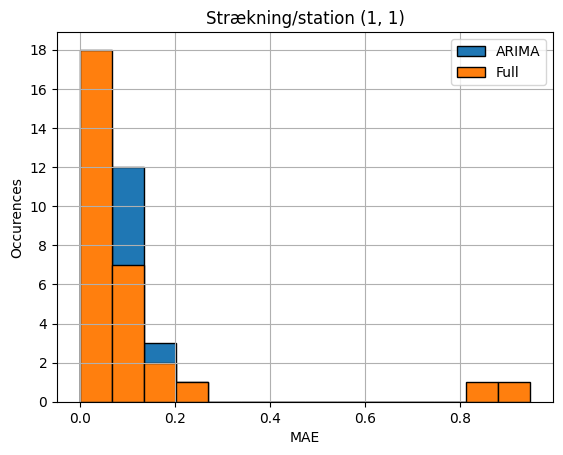

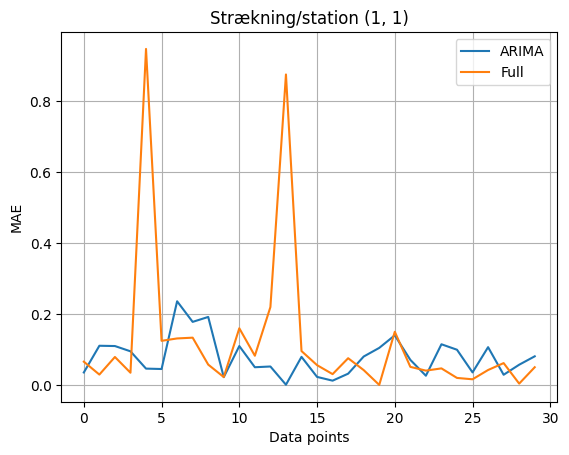

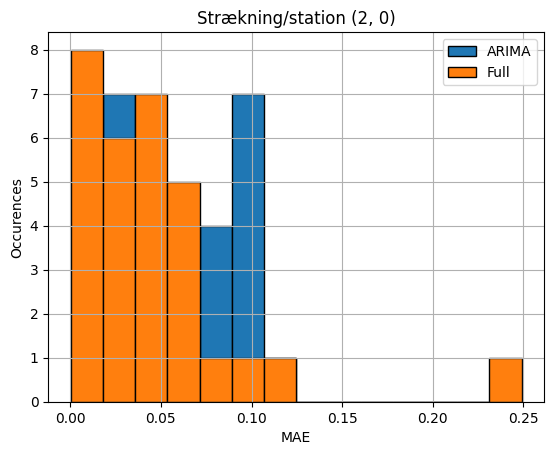

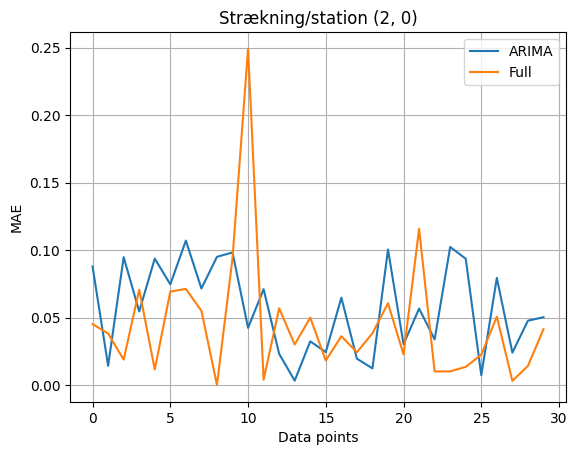

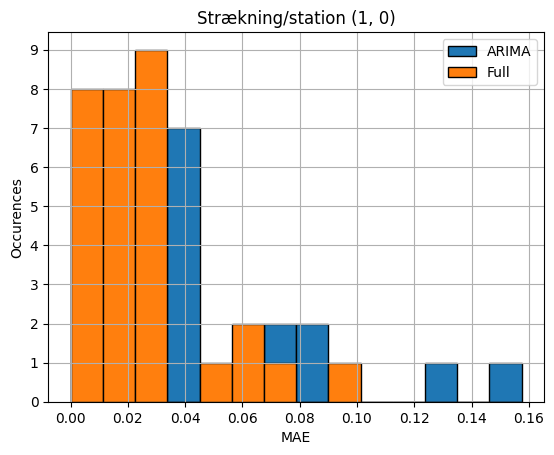

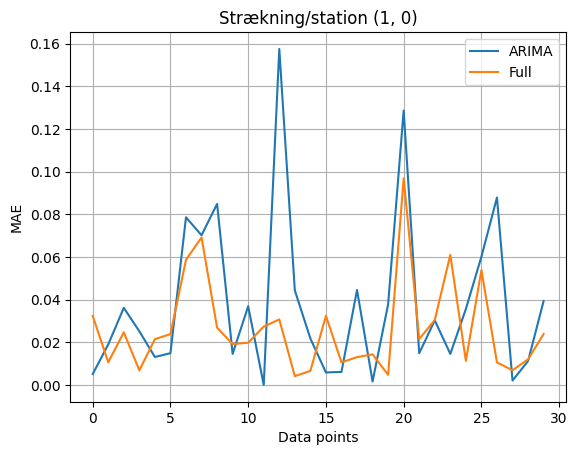

In [60]:
for file in file_list_results:
    strækning_station = ast.literal_eval(file[22:].split('_')[0])
    results_df = pd.read_csv(file)
    cv_full = results_df['CV_score_full']
    cv_arima = results_df['CV_score_arima']
    plot_cv_scores(strækning_station, cv_full, cv_arima)
    

# Predictions

In [ ]:
# Get true values from dataframe as well

In [61]:
for file in file_list_results:
    strækning_station = ast.literal_eval(file[22:].split('_')[0])
    results_df = pd.read_csv(file)
    pred_full = results_df['Predictions_full']
    pred_arima = results_df['Predictions_arima']
    # plot preds

In [ ]:
results = pd.read_csv('Results/Separate_Runs/(1, 0)_SARIMA_Boosted0_results30.csv')
features = pd.read_csv('Results/Separate_Runs/(1, 0)_SARIMA_Boosted0_feature_importances30.csv')